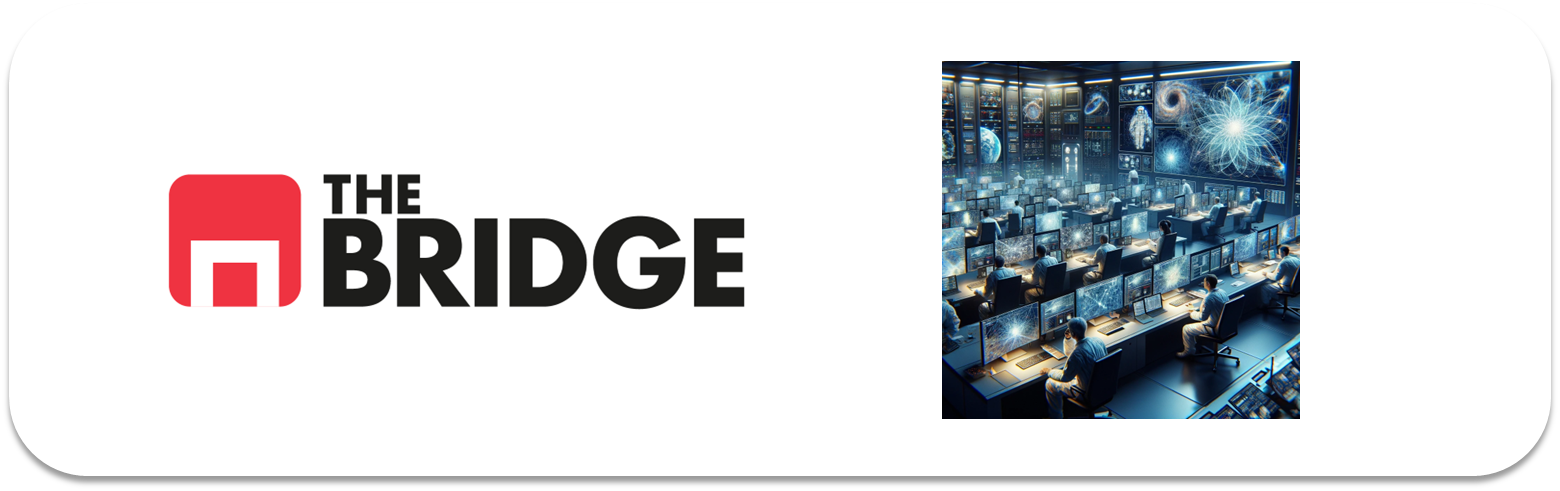

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
from skimage.io import imread
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import Model
from keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
# Procedemos a importar los datos desde la carpeta data
ROOT_PATH = './data/'
PRED_PATH = ROOT_PATH + "seg_pred/"
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
# 1. Preparar los datos del modelo y las funciones de visualización,
# copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

In [4]:
def read_data(directorio, reshape_dim = (150,150)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
# -------------------------------
# PARÁMETROS AJUSTADOS PARA RENDIMIENTO
# -------------------------------
IMG_SIZE = 96  # menor tamaño que 150x150
BATCH_SIZE = 32
EPOCHS = 20
STEPS_PER_EPOCH = 100     # reducimos número de épocas para mejorar la velocidad de entrenamiento
VALIDATION_STEPS = 50
LEARNING_RATE = 1e-4

In [6]:
# -------------------------------
# GENERADORES CON PREPROCESAMIENTO DE VGG19
# -------------------------------
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [7]:
# 2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/)
# (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [8]:
# -------------------------------
# MODELO VGG-19 + CABEZA PERSONALIZADA
# -------------------------------
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             

 Total params: 20,615,110 (78.64 MB)

 Trainable params: 590,726 (2.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [9]:
# 4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida.
# Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [10]:
# -------------------------------
# EARLY STOPPING
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# -------------------------------
# ENTRENAMIENTO RÁPIDO
# -------------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.3938 - loss: 11.7747 - val_accuracy: 0.8313 - val_loss: 1.4055
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.7387 - loss: 2.7116 - val_accuracy: 0.8644 - val_loss: 1.0395
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7864 - loss: 1.7873 - val_accuracy: 0.8544 - val_loss: 0.9744
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7772 - loss: 1.2728 - val_accuracy: 0.8750 - val_loss: 0.7382
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8033 - loss: 1.1089 - val_accuracy: 0.8794 - val_loss: 0.6347
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8030 - loss: 1.0709 - val_accuracy: 0.8731 - val_loss: 0.6319
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8414 - loss: 0.7165 - val_accuracy: 0.8737 - val_loss: 0.5919
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8402 - loss: 0.7287 - val_acc

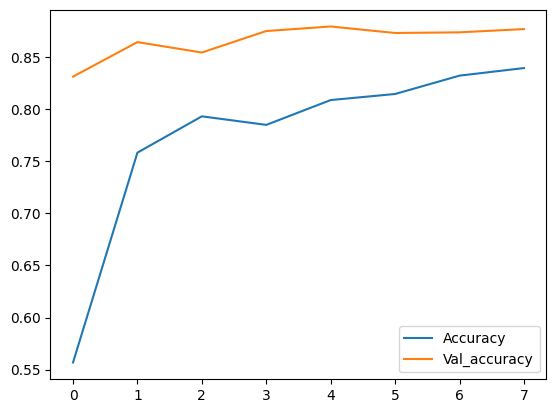

In [11]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

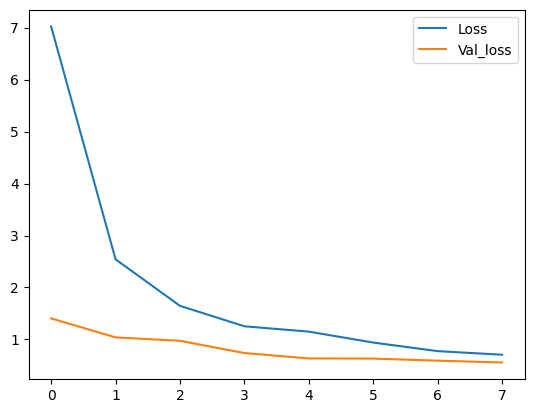

In [12]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [13]:
# Evaluación contra test

loss, acc = model.evaluate(val_generator, verbose=0)
print(f"Accuracy en test: {acc:.2f}")


Accuracy en test: 0.87


In [14]:
# Predicciones de probabilidad
y_pred_probs = model.predict(val_generator, verbose=1)

# Predicciones finales (índice de clase más probable)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = val_generator.classes

# Etiquetas en texto (nombres de clase)
class_names = list(val_generator.class_indices.keys())


88/88 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step


In [15]:
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.17      0.16      0.17       438
      forest       0.15      0.15      0.15       454
     glacier       0.14      0.14      0.14       480
    mountain       0.15      0.14      0.14       502
         sea       0.19      0.19      0.19       454
      street       0.16      0.18      0.17       476

    accuracy                           0.16      2804
   macro avg       0.16      0.16      0.16      2804
weighted avg       0.16      0.16      0.16      2804



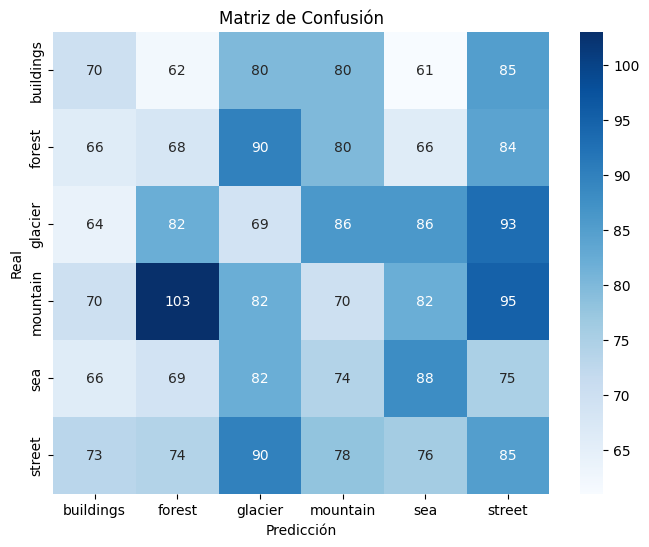

In [16]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


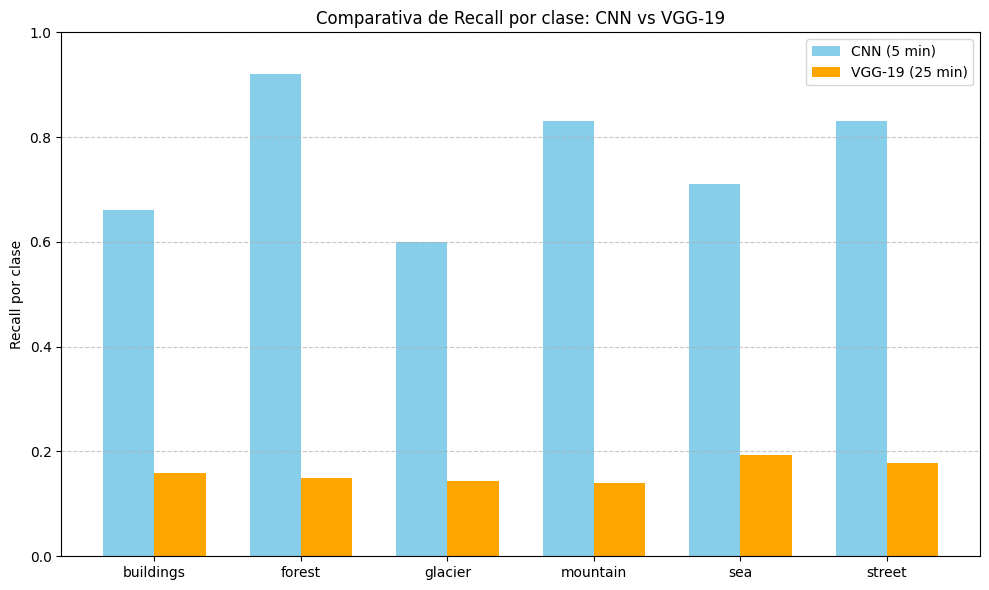

In [17]:
# 6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

# Obtenemos los Recall por clase para CNN (Redes Convolucionales) propia del ejercicio anterior (ignoramos 'accuracy', 'macro avg' y 'yweighted avg')
#                 precision   recall   f1-score   support

#    buildings       0.74      0.66      0.70       437
#       forest       0.88      0.92      0.90       474
#      glacier       0.82      0.60      0.69       553
#     mountain       0.64      0.83      0.72       525
#          sea       0.77      0.71      0.74       510
#       street       0.75      0.83      0.79       501

recall_cnn = [0.66, 0.92, 0.60, 0.83, 0.71, 0.83]

# Obtenemos los Recall por clase para VGG-19 (ignoramos 'accuracy', 'macro avg' y 'yweighted avg')
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
recall_vgg = [report[label]['recall'] for label in class_names]

# Tiempo estimado de entrenamiento en minutos
time_cnn = 5  # 5 minutos
time_vgg = 25  # 25 minutos

x = np.arange(len(class_names))  # posición de las barras
width = 0.35  # ancho de las barras

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, recall_cnn, width, label=f'CNN ({time_cnn} min)', color='skyblue')
bars2 = ax.bar(x + width/2, recall_vgg, width, label=f'VGG-19 ({time_vgg} min)', color='orange')

# Etiquetas y título
ax.set_ylabel('Recall por clase')
ax.set_title('Comparativa de Recall por clase: CNN vs VGG-19')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, 1)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfica
plt.tight_layout()
plt.show()


- Repetir el transfer learning empleando aumentado de imágenes.

In [18]:
# Generador con aumentos para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Generador para validación (sin aumentos, solo normalización)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [19]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6351 - loss: 2.3864 - val_accuracy: 0.8700 - val_loss: 0.5328
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.7079 - loss: 1.0963 - val_accuracy: 0.8725 - val_loss: 0.4904
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.7095 - loss: 1.1111 - val_accuracy: 0.8712 - val_loss: 0.4767
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7244 - loss: 0.8658 - val_accuracy: 0.8625 - val_loss: 0.4764
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.7331 - loss: 0.8841 - val_accuracy: 0.8687 - val_loss: 0.4508


In [20]:
# Obtener las predicciones
y_pred_probs = model.predict(val_generator, verbose=1)

# Convertir a etiquetas predichas (clase más probable)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = val_generator.classes

# Nombres de clases en orden
class_names = list(val_generator.class_indices.keys())


88/88 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step


              precision    recall  f1-score   support

   buildings       0.18      0.18      0.18       438
      forest       0.20      0.20      0.20       454
     glacier       0.19      0.19      0.19       480
    mountain       0.17      0.16      0.16       502
         sea       0.17      0.18      0.18       454
      street       0.16      0.16      0.16       476

    accuracy                           0.18      2804
   macro avg       0.18      0.18      0.18      2804
weighted avg       0.18      0.18      0.18      2804



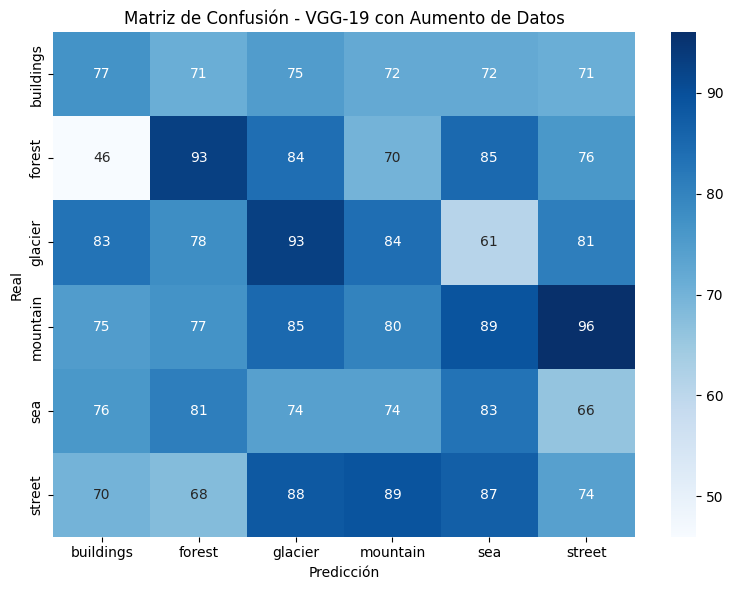

In [21]:
# Reporte de clasificación
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - VGG-19 con Aumento de Datos')
plt.tight_layout()
plt.show()


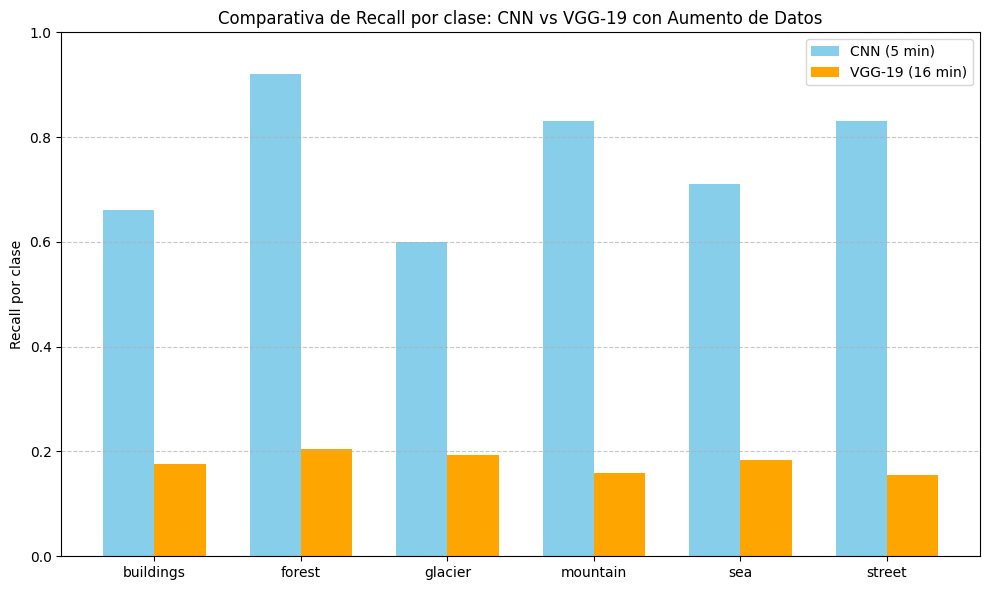

In [22]:
# Obtenemos los Recall por clase para CNN (Redes Convolucionales) propia del ejercicio anterior (ignoramos 'accuracy', 'macro avg' y 'yweighted avg')
#                 precision   recall   f1-score   support

#    buildings       0.74      0.66      0.70       437
#       forest       0.88      0.92      0.90       474
#      glacier       0.82      0.60      0.69       553
#     mountain       0.64      0.83      0.72       525
#          sea       0.77      0.71      0.74       510
#       street       0.75      0.83      0.79       501

recall_cnn = [0.66, 0.92, 0.60, 0.83, 0.71, 0.83]

# Obtenemos los Recall por clase para VGG-19 (ignoramos 'accuracy', 'macro avg' y 'yweighted avg')
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
recall_vgg_augmented = [report[label]['recall'] for label in class_names]

# Tiempo estimado de entrenamiento en minutos
time_cnn = 5  # 5 minutos
time_vgg_augmented = 16  # 16 minutos

x = np.arange(len(class_names))  # posición de las barras
width = 0.35  # ancho de las barras

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, recall_cnn, width, label=f'CNN ({time_cnn} min)', color='skyblue')
bars2 = ax.bar(x + width/2, recall_vgg_augmented, width, label=f'VGG-19 ({time_vgg_augmented} min)', color='orange')

# Etiquetas y título
ax.set_ylabel('Recall por clase')
ax.set_title('Comparativa de Recall por clase: CNN vs VGG-19 con Aumento de Datos')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0, 1)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfica
plt.tight_layout()
plt.show()